# Imports

In [26]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns
import category_encoders as ce

import matplotlib.pyplot as plt

from mrmr import mrmr_regression

from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from feature_engine import encoding
from feature_engine import creation
from feature_engine import imputation

from sklearn.metrics           import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection   import KFold
from sklearn.feature_selection import SelectFromModel

## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
def jupyter_settings():
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 500

jupyter_settings()

In [4]:
def get_metrics(y_true, y_pred):

    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"R2: {r2}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}")

# Loading Datasets

In [5]:
df_train = pd.read_parquet('../data/processed/V0.2_dataframe_train.parquet')
df_oot = pd.read_parquet('../data/processed/V0.2_dataframe_oot.parquet')

## Columns

In [6]:
df_train.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [7]:
df_oot.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

## Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df_train.shape[0]))
print('Number of Cols: {}'.format(df_train.shape[1]))

Number of Rows: 77853
Number of Cols: 147


In [9]:
print('Number of Rows: {}'.format(df_oot.shape[0]))
print('Number of Cols: {}'.format(df_oot.shape[1]))

Number of Rows: 18603
Number of Cols: 147


## Data Types

In [10]:
df_train.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [11]:
df_oot.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

## Check NA

In [12]:
df_train.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002697
customer_lng                                0.002697
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002440
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002453
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.005112
distance_customer_seller_max                0.

In [13]:
df_oot.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002903
customer_lng                                0.002903
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.001398
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.001398
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004193
distance_customer_seller_max                0.

## Splitting into X and y

In [14]:
list_columns = [
    'order_purchase_timestamp', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'delivered_in_days', 'estimated_delivery_in_days', 'time']

X_train = df_train.drop(columns=list_columns)
X_oot = df_oot.drop(columns=list_columns)

In [15]:
target = 'delivered_in_days'
list_columns = ['delivered_in_days', 'estimated_delivery_in_days']

y_train = df_train.loc[:, list_columns]
y_oot = df_oot.loc[:, list_columns]

# Feature Engineering

## Fill NA

In [16]:
categorical_variables = X_train.select_dtypes(include='object').columns.tolist()

In [17]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)
X_train = cat_imputer.fit_transform(X_train)
X_oot = cat_imputer.transform(X_oot)

## Categorical Encoding

In [18]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)

X_train = cat_imputer.fit_transform(X_train)
X_oot = cat_imputer.fit_transform(X_oot)

In [19]:
rare_label_encoder = encoding.RareLabelEncoder(variables=categorical_variables)

X_train = rare_label_encoder.fit_transform(X_train)
X_oot = rare_label_encoder.transform(X_oot)

In [20]:
count_encoder = ce.CountEncoder(
    cols=None, return_df=True, handle_unknown='value', 
    handle_missing='value', normalize=True)

X_train[[c + '_ce' for c in categorical_variables]] = count_encoder.fit_transform(X_train[categorical_variables])
X_oot[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_oot[categorical_variables])

In [21]:
target_encoder = ce.TargetEncoder(
    cols=None, return_df=False, handle_missing='value', handle_unknown='value')

X_train[[c + '_te' for c in categorical_variables]] = target_encoder.fit_transform(X_train[categorical_variables], y_train[target])
X_oot[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_oot[categorical_variables])

## Cyclical Features

In [22]:
cyclical_variables = [
    'order_purchase_timestamp_second', 'order_purchase_timestamp_minute', 'order_purchase_timestamp_hour', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month',
    'order_approved_at_second', 'order_approved_at_minute', 'order_approved_at_hour', 'order_approved_at_day', 'order_approved_at_month']

cyclical_features = creation.CyclicalFeatures(variables=cyclical_variables, max_values=None, drop_original=False)
X_train = cyclical_features.fit_transform(X_train)
X_oot = cyclical_features.transform(X_oot)

## Removing Features

In [23]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

X_train = X_train.drop(columns=categorical_columns)
X_oot = X_oot.drop(columns=categorical_columns)

In [25]:
list_selected_features_rmrm = mrmr_regression(X=X_train, y=y_train[target], K=50)

100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.14it/s]


In [ ]:
def apply_cross_validation(X, y, cv=3, shuffle=True, random_state=42):

    '''initial'''
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    r2 = []
    mae = []
    rmse = []
    
    
    mm = MinMaxScaler()

# Machine Learning Modeling

## LightGBM Regressor

### First Hyperparameter Tuning

In [34]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_jobs": -1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train[list_feature_selection], y_train[target], eval_set=[(X_valid[list_feature_selection], y_valid[target])])
    
    pred = model.predict(X_valid[list_feature_selection])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 900, 'learning_rate': 0.007292907317290263, 'num_leaves': 429, 'subsample': 0.8318926551781909, 'colsample_bytree': 0.48519180162062786, 'min_data_in_leaf': 76}
Best RMSE: 8.090841159184821


In [30]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'n_estimators': 900, 
    'learning_rate': 0.007292907317290263, 
    'num_leaves': 429, 
    'subsample': 0.8318926551781909, 
    'colsample_bytree': 0.48519180162062786, 
    'min_data_in_leaf': 76}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_feature_selection], y_train[target], eval_set=[(X_valid[list_feature_selection], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_feature_selection])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5539993226695218; RMSE: 6.715316252475621; MAE: 3.9638182081034463; MAPE: 18330549899095.895


In [31]:
y_valid['pred'] = lgbm.predict(X_valid[list_feature_selection])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.32405387505642436; RMSE: 8.090841159184821; MAE: 5.006148301535107; MAPE: 19908444610149.086


In [32]:
y_oot['pred'] = lgbm.predict(X_oot[list_feature_selection])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.004558509350220952; RMSE: 5.820184395437365; MAE: 4.403872464639253; MAPE: 115420933595008.22


### Feature Selection

In [41]:
sfm = SelectFromModel(estimator=LGBMRegressor(**params), threshold='median')
sfm.fit(X_train[list_feature_selection], y_train[target])

SelectFromModel(estimator=LGBMRegressor(bagging_freq=1,
                                        colsample_bytree=0.48519180162062786,
                                        learning_rate=0.007292907317290263,
                                        metric='rmse', min_data_in_leaf=76,
                                        n_estimators=900, n_jobs=-1,
                                        num_leaves=429, objective='regression',
                                        subsample=0.8318926551781909,
                                        verbosity=-1),
                threshold='median')

In [42]:
list_selected_features = X_train[list_feature_selection].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['order_purchase_timestamp_month_cos',
 'distance_customer_seller_min',
 'product_height_cm_q75',
 'distance_customer_seller_q25',
 'distance_customer_seller_mean',
 'order_approved_at_month_sin',
 'freight_value_min',
 'freight_value_q25',
 'customer_lat',
 'freight_value_median',
 'freight_value_q75',
 'customer_lng',
 'order_purchase_timestamp_month_sin',
 'order_approved_at_second_sin',
 'order_approved_at_second_cos',
 'product_length_cm_min',
 'product_weight_g_min',
 'payment_value_max',
 'product_weight_g_q25',
 'product_weight_g_median',
 'payment_value_q75',
 'order_approved_at_second',
 'payment_value_mean',
 'product_length_cm_q25',
 'order_purchase_timestamp_day_cos']

In [43]:
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5388759910932006; RMSE: 6.82822115101657; MAE: 4.050794994144203; MAPE: 18213908040290.785


In [44]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3179654041839791; RMSE: 8.12719791788035; MAE: 5.038674292141478; MAPE: 19318418508993.957


In [45]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.008411398917860025; RMSE: 5.831335098395297; MAE: 4.4124398143644; MAPE: 116313701797463.7


### Second Hyperparamenter Tuning

In [46]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_jobs": -1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 800, 'learning_rate': 0.007267030393106293, 'num_leaves': 540, 'subsample': 0.723059061047022, 'colsample_bytree': 0.8051790541549378, 'min_data_in_leaf': 65}
Best RMSE: 8.128358443621844


In [47]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'n_estimators': 800, 
    'learning_rate': 0.007267030393106293, 
    'num_leaves': 540, 
    'subsample': 0.723059061047022, 
    'colsample_bytree': 0.8051790541549378, 
    'min_data_in_leaf': 65}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5323542803394385; RMSE: 6.876337636418456; MAE: 4.061600406408869; MAPE: 18125817599087.1


In [48]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3177706075946478; RMSE: 8.128358443621844; MAE: 5.039922311893429; MAPE: 19773584057023.953


In [49]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.011258236190021753; RMSE: 5.83956049241351; MAE: 4.422459422523352; MAPE: 114928970382321.3


## CatBoost Regressor

### First Hyperparameter Tuning

In [50]:
def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train[list_feature_selection], y_train[target], eval_set=(X_valid[list_feature_selection], y_valid[target]))
    
    pred = model.predict(X_valid[list_feature_selection])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.032745498785361066, 'depth': 10, 'subsample': 0.8305243726354856, 'colsample_bylevel': 0.9856829961097553, 'min_data_in_leaf': 22}
Best RMSE: 8.154150541561004


In [51]:
params = {
    'iterations': 1000,
    'learning_rate': 0.032745498785361066, 
    'depth': 10, 
    'subsample': 0.8305243726354856, 
    'colsample_bylevel': 0.9856829961097553, 
    'min_data_in_leaf': 22}

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_feature_selection], y_train[target], eval_set=(X_valid[list_feature_selection], y_valid[target]))

y_train['pred'] = cat.predict(X_train[list_feature_selection])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5312840384993824; RMSE: 6.884201643449728; MAE: 4.424817000124115; MAPE: 22208935308491.44


In [52]:
y_valid['pred'] = cat.predict(X_valid[list_feature_selection])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3134341737210725; RMSE: 8.154150541561004; MAE: 5.073431182167834; MAPE: 20077546583868.1


In [53]:
y_oot['pred'] = cat.predict(X_oot[list_feature_selection])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.03279259385218192; RMSE: 5.710957556090126; MAE: 4.301960649674322; MAPE: 115365251192450.12


### Feature Selection

In [55]:
sfm = SelectFromModel(estimator=CatBoostRegressor(**params, silent=True), threshold='median')
sfm.fit(X_train[list_feature_selection], y_train[target])

SelectFromModel(estimator=<catboost.core.CatBoostRegressor object at 0x7f76e9e43670>,
                threshold='median')

In [56]:
list_selected_features = X_train[list_feature_selection].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_state_te',
 'order_purchase_timestamp_month_cos',
 'seller_geolocation_city_mode_te',
 'distance_customer_seller_min',
 'product_height_cm_q75',
 'distance_customer_seller_q25',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q75',
 'customer_state_ce',
 'distance_customer_seller_max',
 'order_approved_at_month_sin',
 'freight_value_min',
 'order_approved_at_month_cos',
 'customer_lat',
 'customer_lng',
 'order_purchase_timestamp_month_sin',
 'order_approved_at_second_sin',
 'product_category_name_mode_te',
 'order_approved_at_second_cos',
 'product_length_cm_min',
 'payment_value_max',
 'order_approved_at_second',
 'product_length_cm_q25',
 'order_purchase_timestamp_day_cos']

In [57]:
cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = cat.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5342000823828218; RMSE: 6.862753734633423; MAE: 4.405256953240855; MAPE: 21714949423414.87


In [58]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.31088735391961075; RMSE: 8.169260475627281; MAE: 5.086681036430114; MAPE: 19943234631175.08


In [59]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.023481595483949458; RMSE: 5.738380503032557; MAE: 4.33172728738076; MAPE: 113865638446290.52


### Second Hyperparameter Tuning

In [61]:
def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=(X_valid[list_selected_features], y_valid[target]))
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.05437865553678633, 'depth': 9, 'subsample': 0.6795051606557011, 'colsample_bylevel': 0.7439944786896, 'min_data_in_leaf': 71}
Best RMSE: 8.158865404317227


In [62]:
params = {
    'iterations': 1000,
    'learning_rate': 0.05437865553678633, 
    'depth': 9, 
    'subsample': 0.6795051606557011, 
    'colsample_bylevel': 0.7439944786896, 
    'min_data_in_leaf': 71}

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = cat.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5624027727987968; RMSE: 6.6517511264904865; MAE: 4.313520159074982; MAPE: 20670843853684.562


In [63]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3126399770750834; RMSE: 8.158865404317227; MAE: 5.072672096137661; MAPE: 19340985670145.94


In [64]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.010183590725347025; RMSE: 5.777320360783727; MAE: 4.347716635674247; MAPE: 112006341997491.81


## XGBoost Regressor

### First Hyperparameter Tuning

In [65]:
def objective(trial):
    
    params = {
        "enable_categorical": True,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)}

    model = XGBRegressor(**params)
    model.fit(X_train[list_feature_selection], y_train[target], eval_set=[(X_valid[list_feature_selection], y_valid[target])], verbose=False)
    
    pred = model.predict(X_valid[list_feature_selection])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 800, 'learning_rate': 0.0121902803576664, 'max_depth': 10, 'subsample': 0.9873900476508854, 'colsample_bytree': 0.5738134422901474, 'min_child_weight': 11}
Best RMSE: 8.128372815428195


In [67]:
params = {
    'enable_categorical': True,
    'n_estimators': 800, 
    'learning_rate': 0.0121902803576664, 
    'max_depth': 10, 
    'subsample': 0.9873900476508854, 
    'colsample_bytree': 0.5738134422901474, 
    'min_child_weight': 11}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_feature_selection], y_train[target], eval_set=[(X_valid[list_feature_selection], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_feature_selection])
get_metrics(y_train[target], y_train['pred'])

R2: 0.6230210268575033; RMSE: 6.173867073527495; MAE: 3.8396376241892316; MAPE: 17918749641404.234


In [68]:
y_valid['pred'] = xgb.predict(X_valid[list_feature_selection])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3177681950835727; RMSE: 8.128372815428195; MAE: 5.047109542718172; MAPE: 19850227737483.414


In [69]:
y_oot['pred'] = xgb.predict(X_oot[list_feature_selection])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.016815157663998326; RMSE: 5.855582869973155; MAE: 4.4265316764507245; MAPE: 115389498539861.16


### Feature Selecion

In [70]:
sfm = SelectFromModel(estimator=XGBRegressor(**params), threshold='median')
sfm.fit(X_train[list_feature_selection], y_train[target])

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=0.5738134422901474,
                                       device=None, early_stopping_rounds=None,
                                       enable_categorical=True,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=0.0121902803576664,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=10,
                                       max_leaves=None, min_child_weight=11,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=800,
                                       n_jobs=None, num_parallel_tree=None,
                                       random_state=None, ...),
                threshold='median')

In [72]:
list_selected_features = X_train[list_feature_selection].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_state_te',
 'order_purchase_timestamp_month_cos',
 'seller_geolocation_city_mode_te',
 'distance_customer_seller_min',
 'product_height_cm_q75',
 'distance_customer_seller_q25',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q75',
 'customer_state_ce',
 'distance_customer_seller_max',
 'order_approved_at_month_sin',
 'customer_city_te',
 'freight_value_min',
 'order_approved_at_month_cos',
 'freight_value_q25',
 'customer_lat',
 'freight_value_median',
 'freight_value_mean',
 'customer_lng',
 'order_purchase_timestamp_month_sin',
 'product_category_name_mode_te',
 'product_name_lenght_range',
 'product_weight_g_min',
 'product_weight_g_q25']

In [73]:
xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5659513153057836; RMSE: 6.624726196591506; MAE: 4.111851777525502; MAPE: 20115647861410.465


In [74]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3122783192802119; RMSE: 8.161011535268198; MAE: 5.070149174926067; MAPE: 19862568621882.586


In [75]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.035385326681014906; RMSE: 5.908811407860756; MAE: 4.461933884217983; MAPE: 115919574339381.69


### Second Hyperparameter Tuning

In [76]:
def objective(trial):
    
    params = {
        "enable_categorical": True,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)}

    model = XGBRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 900, 'learning_rate': 0.011001077586040303, 'max_depth': 10, 'subsample': 0.8178248519918834, 'colsample_bytree': 0.4126170284432086, 'min_child_weight': 16}
Best RMSE: 8.146327709713486


In [77]:
params = {
    'enable_categorical': True,
    'n_estimators': 900, 
    'learning_rate': 0.011001077586040303, 
    'max_depth': 10, 
    'subsample': 0.8178248519918834, 
    'colsample_bytree': 0.4126170284432086, 
    'min_child_weight': 16}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5300079387753953; RMSE: 6.893566543865124; MAE: 4.255197813125529; MAPE: 21207598214947.754


In [78]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.31475088050839484; RMSE: 8.146327709713486; MAE: 5.062952112941825; MAPE: 19911399551437.656


In [79]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.028091372634243994; RMSE: 5.887961792637936; MAE: 4.443979811080135; MAPE: 115259270446993.06


# Result Analysis

## Final Model

In [80]:
list_selected_columns = [
    'customer_state_te',
    'order_purchase_timestamp_month_cos',
    'seller_geolocation_city_mode_te',
    'distance_customer_seller_min',
    'product_height_cm_q75',
    'distance_customer_seller_q25',
    'distance_customer_seller_mean',
    'distance_customer_seller_median',
    'distance_customer_seller_q75',
    'customer_state_ce',
    'distance_customer_seller_max',
    'order_approved_at_month_sin',
    'freight_value_min',
    'order_approved_at_month_cos',
    'customer_lat',
    'customer_lng',
    'order_purchase_timestamp_month_sin',
    'order_approved_at_second_sin',
    'product_category_name_mode_te',
    'order_approved_at_second_cos',
    'product_length_cm_min',
    'payment_value_max',
    'order_approved_at_second',
    'product_length_cm_q25',
    'order_purchase_timestamp_day_cos']

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'n_estimators': 800, 
    'learning_rate': 0.007267030393106293, 
    'num_leaves': 540, 
    'subsample': 0.723059061047022, 
    'colsample_bytree': 0.8051790541549378, 
    'min_data_in_leaf': 65}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.4979259983120897; RMSE: 7.124962416147178; MAE: 4.245302299848713; MAPE: 19912083056132.742


In [81]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3170137650462873; RMSE: 8.132865858838715; MAE: 5.047424292851246; MAPE: 20064483742480.797


In [82]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.024318557905601557; RMSE: 5.877148256483519; MAE: 4.438066357376776; MAPE: 112563758664068.47


### Feature Importances

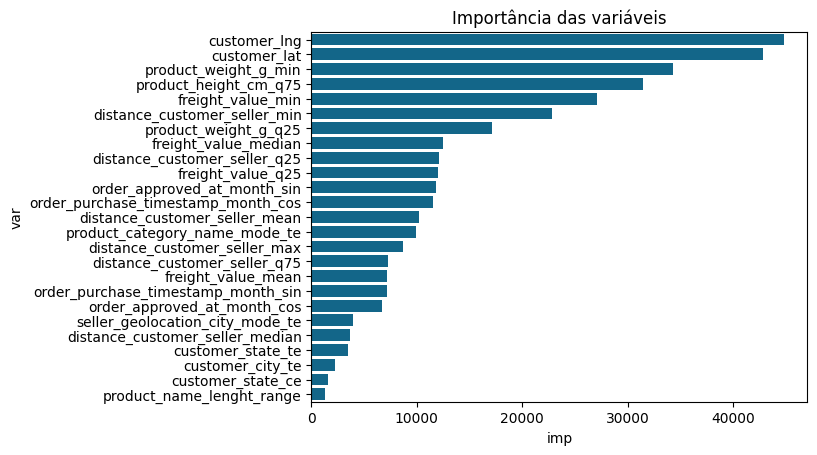

In [83]:
imp = pd.DataFrame(lgbm.feature_importances_, X_train[list_selected_features].columns).reset_index()
imp.columns = ["var", "imp"]
imp = imp.sort_values("imp", ascending=False)

sns.barplot(x="imp", y="var", color="#006e9cff", data=imp.iloc[:30])

plt.title(f"Importância das variáveis")
plt.show()

### Shap Values

In [84]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train[list_selected_features])

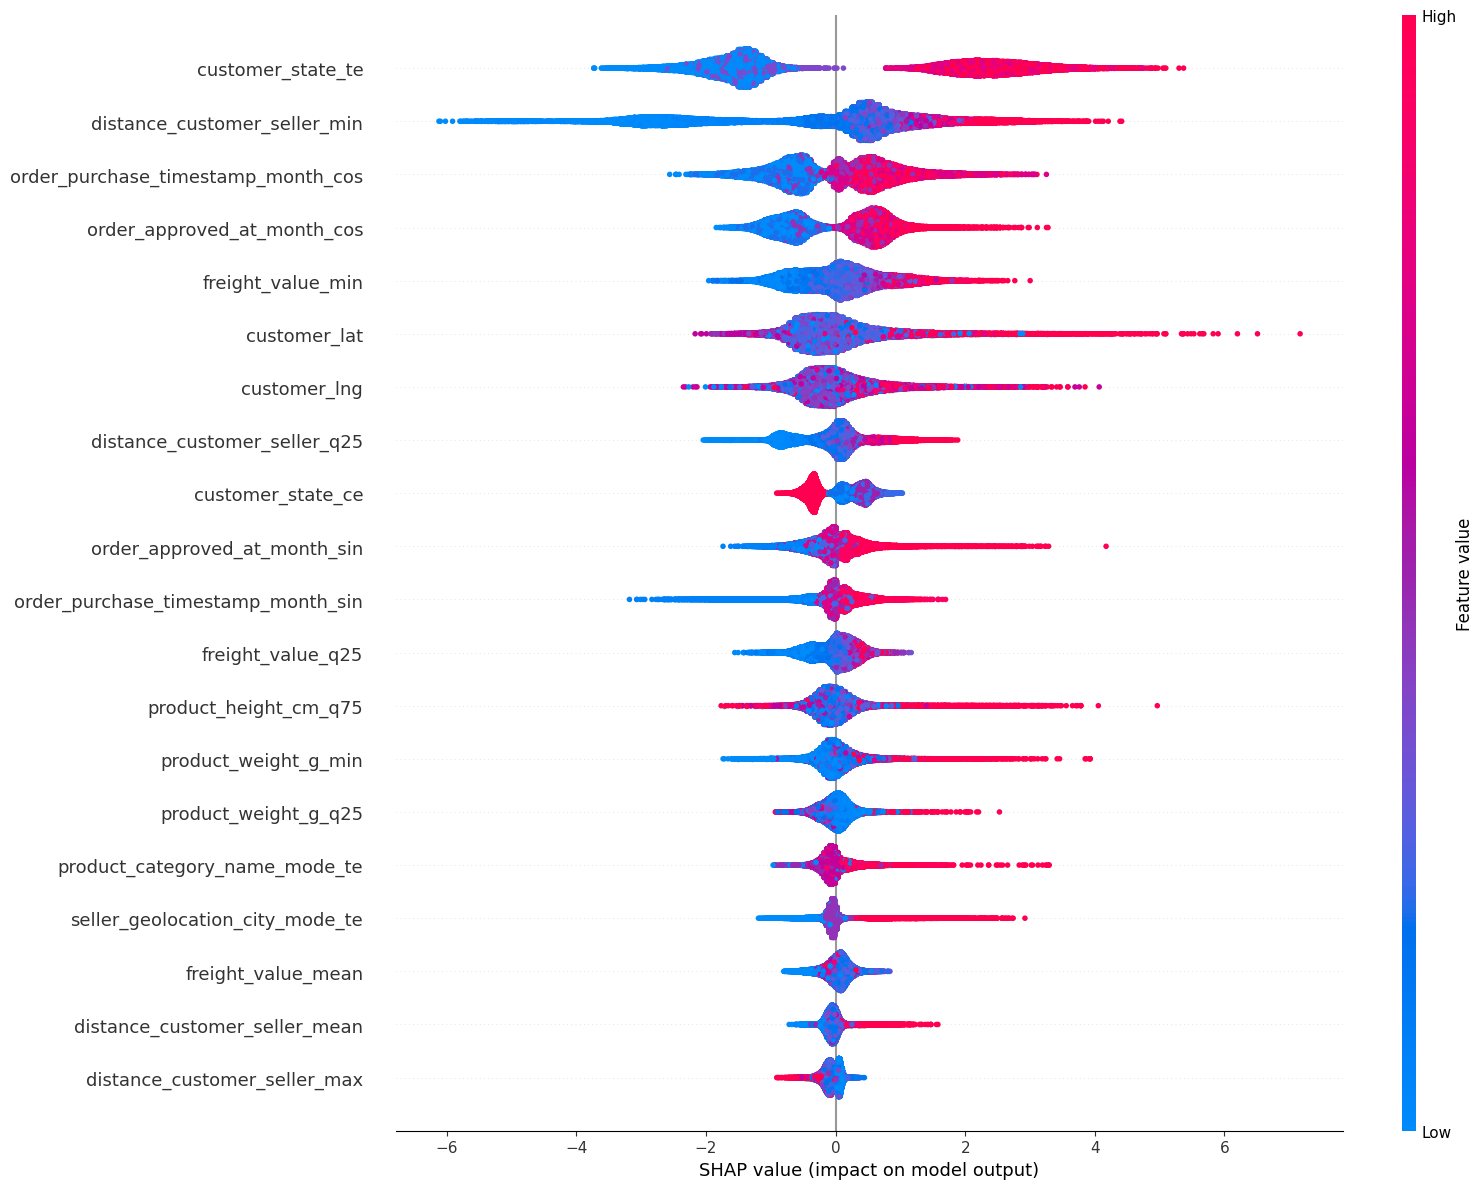

,index,impact
0,customer_state_te,1.946727
3,distance_customer_seller_min,1.245184
1,order_purchase_timestamp_month_cos,0.697321
14,order_approved_at_month_cos,0.686078
13,freight_value_min,0.506185
16,customer_lat,0.494992
19,customer_lng,0.403109
5,distance_customer_seller_q25,0.382959
9,customer_state_ce,0.351153
11,order_approved_at_month_sin,0.291415


In [99]:
shap.summary_plot(shap_values, X_train[list_selected_features], plot_size=(16, 12))

shap_df = pd.DataFrame(np.abs(shap_values), columns=list_selected_features)
shap_df = (
    pd.DataFrame(shap_df.mean(), columns=["impact"]).reset_index()
    .rename(columns={"level_0": "var"})
    .sort_values(by=["impact"], ascending=False))

display(shap_df)

## Analysis of Estimated Values

### Train Values

In [86]:
get_metrics(y_train[target], y_train['estimated_delivery_in_days'])

R2: -1.2710958645968153; RMSE: 15.15362181073755; MAE: 12.798987749467994; MAPE: 63632846865898.91


In [87]:
get_metrics(y_train[target], y_train['pred'])

R2: 0.4979259983120897; RMSE: 7.124962416147178; MAE: 4.245302299848713; MAPE: 19912083056132.742


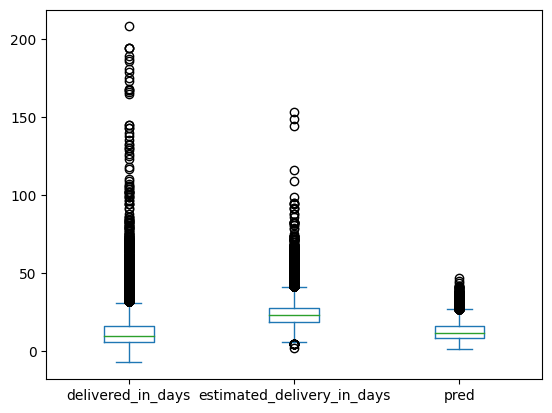

In [88]:
y_train.plot(kind='box');

### Valid Values

In [89]:
get_metrics(y_valid[target], y_valid['estimated_delivery_in_days'])

R2: -1.3023139893957243; RMSE: 14.932066313490298; MAE: 12.686517203798848; MAPE: 58722788228598.95


In [90]:
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3170137650462873; RMSE: 8.132865858838715; MAE: 5.047424292851246; MAPE: 20064483742480.797


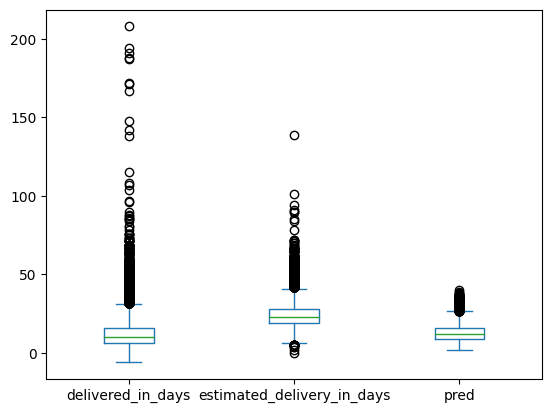

In [91]:
y_valid.plot(kind='box');

### OoT Values

In [92]:
get_metrics(y_oot[target], y_oot['estimated_delivery_in_days'])

R2: -6.096547120243494; RMSE: 15.469371569468713; MAE: 12.755738321776057; MAPE: 243542505248334.34


In [93]:
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.024318557905601557; RMSE: 5.877148256483519; MAE: 4.438066357376776; MAPE: 112563758664068.47


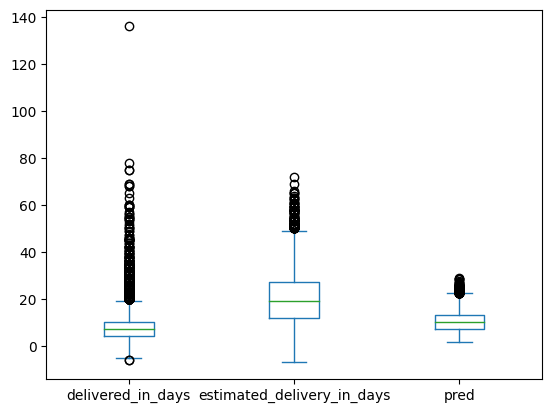

In [94]:
y_oot.plot(kind='box');

### Metrics over Time

In [95]:
df_aux = pd.concat([df_valid[['time']], df_oot[['time']]], axis=0)
df_aux1 = pd.concat([y_valid, y_oot], axis=0)

df_aux = pd.concat([df_aux, df_aux1], axis=1)

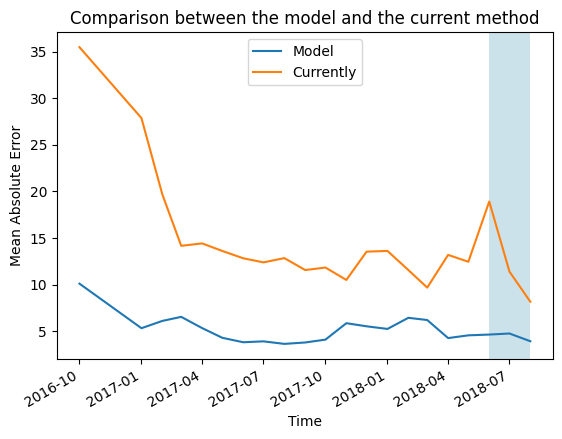

In [96]:
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['pred'])).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['estimated_delivery_in_days'])).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best');

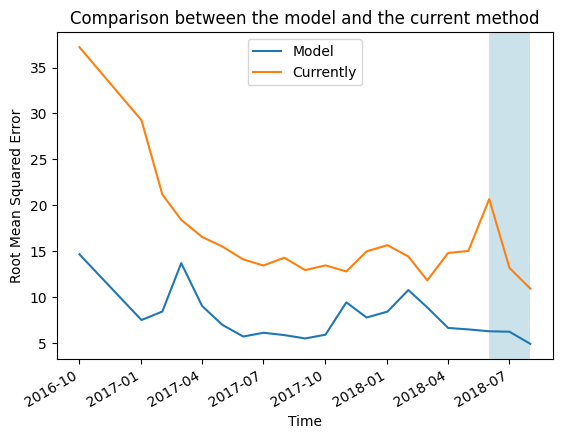

In [97]:
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['pred'], squared=False)).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['estimated_delivery_in_days'], squared=False)).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='best');